In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn import metrics

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
import sklearn.metrics as skmetrics
import warnings
from statsmodels.tsa.stattools import arma_order_select_ic
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import pmdarima as pm

#ETS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Prophet
from pmdarima.arima import auto_arima
from prophet import Prophet

warnings.filterwarnings("ignore")

In [2]:
series = pd.read_csv('zillow-carlifornia.csv',header=0, index_col=0, parse_dates=True, squeeze=True)
series.shape

(107, 3)

In [3]:
series.tail()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2016-08-31,NaN,3.46,4.8
2016-09-30,NaN,3.42,5.0
2016-10-31,NaN,3.36,5.0
2016-11-30,NaN,3.47,4.8
2016-12-31,NaN,4.07,4.7


In [4]:
series['MedianSoldPrice_AllHomes.California']

Date
2008-02-29    470000.0
2008-03-31    441000.0
2008-04-30    460000.0
2008-05-31    429000.0
2008-06-30    437500.0
                ...   
2016-08-31         NaN
2016-09-30         NaN
2016-10-31         NaN
2016-11-30         NaN
2016-12-31         NaN
Name: MedianSoldPrice_AllHomes.California, Length: 107, dtype: float64

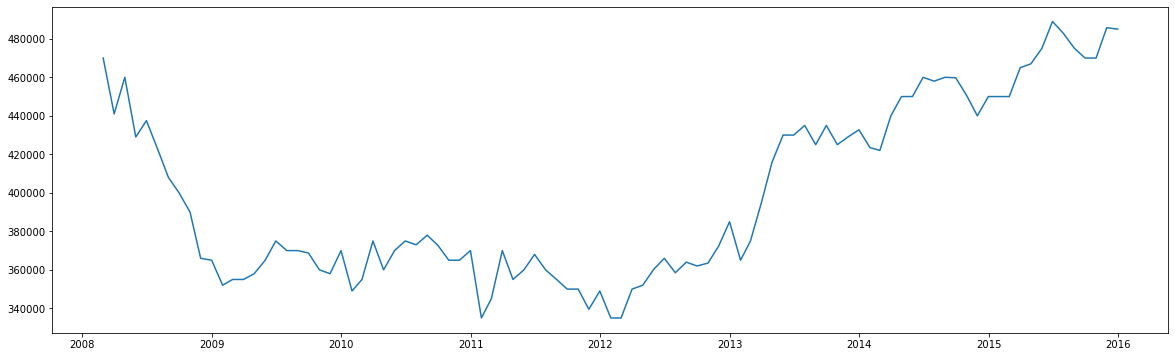

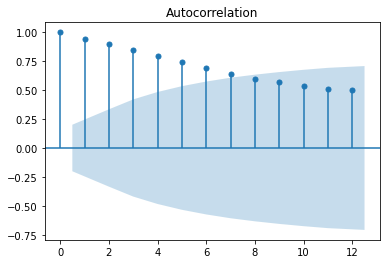

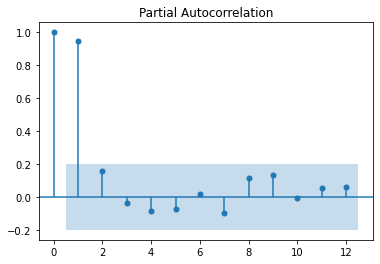

In [5]:
data = series['MedianSoldPrice_AllHomes.California'].dropna()
x=np.array(data)
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.plot(data)
plt.show()
plot_acf(data,lags=12) 
plt.show()
plot_pacf(data,lags=12) 
plt.show()

In [6]:
# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [7]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

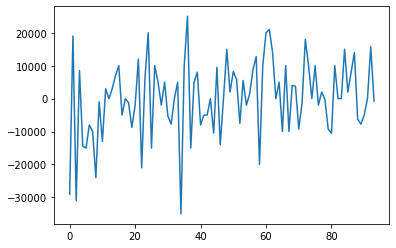

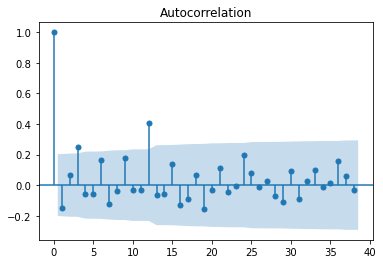

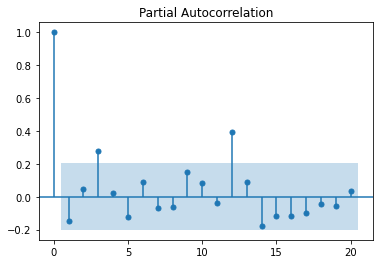

In [8]:
# fit a trend only model 
# determine d
d1 = diff(data, 1)
plt.plot(d1)
plot_acf(d1,lags=38) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()

In [9]:
dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


# SARIMA Model

In [10]:
series

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2016-08-31,NaN,3.46,4.8
2016-09-30,NaN,3.42,5.0
2016-10-31,NaN,3.36,5.0


In [11]:
dt = series.dropna()
dt

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0


In [12]:
#sarimax 

#drop na and normalize the features X for better prediction
#you can use StandardScaler too
#train and test
period = 12
train, test = dt[0:-period], dt[-period:]

#scale data

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [13]:
#auto sarimax search without seasonality
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,0], # gdp as endogenous
                 exogenous= train_sc[:,1:], # rest as exogenous
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 m=4, D=1, max_P=3, max_Q=3,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=-62.237, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=-52.826, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=-122.010, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=-93.178, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=-54.755, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=-110.813, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=-162.325, Time=0.23 sec
 ARIMA(1,0,0)(3,1,0)[4] intercept   : AIC=-161.377, Time=0.32 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=-161.841, Time=0.27 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=-142.014, Time=0.19 sec
 ARIMA(1,0,0)(3,1,1)[4] intercept   : AIC=-158.855, Time=0.37 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=-52.275, Time=0.09 sec
 ARIMA(2,0,0)(2,1,0)[4] intercept   : AIC=-164.945, Time=0.25 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=-122.057, Time=0.19 sec
 ARIMA(2,0,0)(3,1,0)[4] intercept   : 

In [14]:
y_pred = model.predict(n_periods=len(test_sc),X=test_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column

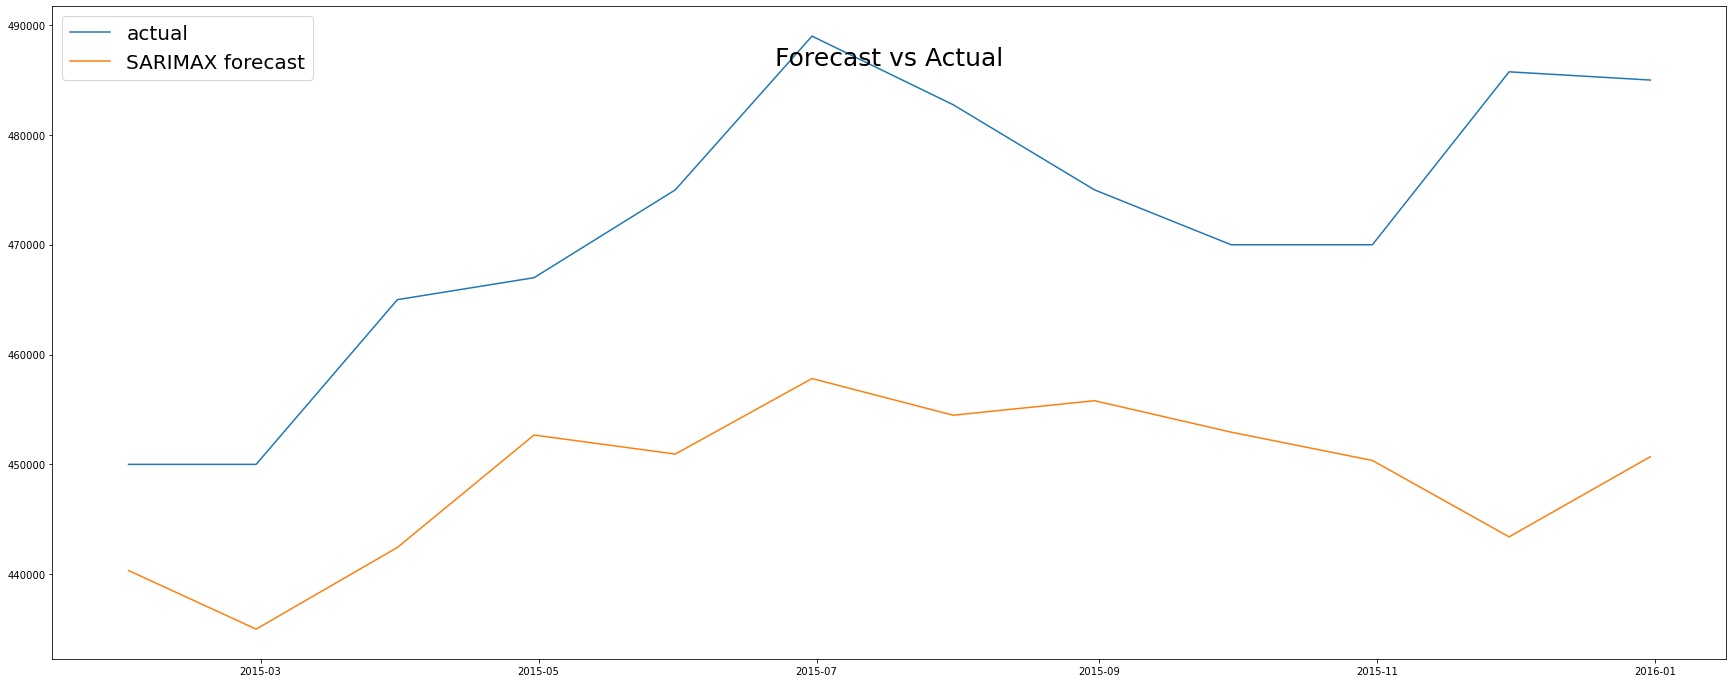

In [15]:
y_pred_series = pd.Series(y_pred_inv,index=test.index)
plt.figure(figsize=(30, 12))

plt.plot(test['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [16]:
mape_test_sarimax=(np.abs(np.array(test['MedianSoldPrice_AllHomes.California'])-np.array(y_pred_inv))/np.array(test['MedianSoldPrice_AllHomes.California'])).mean()

In [18]:
rmse = np.sqrt(metrics.mean_squared_error(np.array(test['MedianSoldPrice_AllHomes.California'])-np.array(y_pred_inv),np.array(y_pred)))

In [20]:
print(mape_test_sarimax, rmse)

0.048623556615757346 24832.302835450046


# ETS Model

In [21]:
df = pd.read_csv('zillow-carlifornia.csv', parse_dates=True)
df['Date']= pd.to_datetime(df['Date'])
df

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2
...,...,...,...,...
102,2016-08-31,NaN,3.46,4.8
103,2016-09-30,NaN,3.42,5.0
104,2016-10-31,NaN,3.36,5.0
105,2016-11-30,NaN,3.47,4.8


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 107 non-null    datetime64[ns]
 1   MedianSoldPrice_AllHomes.California  95 non-null     float64       
 2   MedianMortageRate                    107 non-null    float64       
 3   UnemploymentRate                     107 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.5 KB


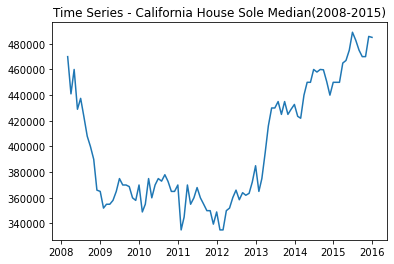

In [24]:
history = df[df['Date'] <= '2015-12-31']['MedianSoldPrice_AllHomes.California']
x_axis = df[df['Date'] <= '2015-12-31']['Date']
pyplot.plot(x_axis, history)
pyplot.title('Time Series - California House Sole Median(2008-2015)')
pyplot.show()

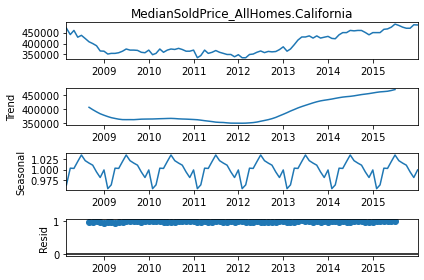

In [26]:
history.index = x_axis
result = seasonal_decompose(history, model='multiplicative',freq=12)
result.plot()
plt.show()

In [28]:
history

Date
2008-02-29    470000.0
2008-03-31    441000.0
2008-04-30    460000.0
2008-05-31    429000.0
2008-06-30    437500.0
                ...   
2015-08-31    475000.0
2015-09-30    470000.0
2015-10-31    470000.0
2015-11-30    485750.0
2015-12-31    485000.0
Name: MedianSoldPrice_AllHomes.California, Length: 95, dtype: float64

In [30]:
test = pd.read_csv('test.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
test

Month
2016-01-31    476250
2016-02-29    466000
2016-03-31    485000
2016-04-30    501000
2016-05-31    501000
2016-06-30    505000
2016-07-31    507000
2016-08-31    510000
2016-09-30    510000
2016-10-31    523000
2016-11-30    506000
2016-12-31    510000
Name: Median House Price, dtype: int64

In [31]:
model1_ = ExponentialSmoothing(history, trend="add", seasonal="add", seasonal_periods=12,damped_trend=True)
model2_ = ExponentialSmoothing(history, trend="add", seasonal="mul", seasonal_periods=12, damped_trend=True)
model3_ = ExponentialSmoothing(history, trend="mul", seasonal="add", seasonal_periods=12,damped_trend=True)
model4_ = ExponentialSmoothing(history, trend="mul", seasonal="mul", seasonal_periods=12, damped_trend=True)
model5_ = ExponentialSmoothing(history, trend=None, seasonal="add", seasonal_periods=12,damped_trend=False)
model6_ = ExponentialSmoothing(history, trend=None, seasonal="mul", seasonal_periods=12, damped_trend=False)

fit1_ = model1_.fit()
pred1_ = fit1_.forecast(len(test))
fit2_ = model2_.fit()
pred2_ = fit2_.forecast(len(test))
fit3_ = model3_.fit()
pred3_ = fit3_.forecast(len(test))
fit4_ = model4_.fit()
pred4_ = fit4_.forecast(len(test))
fit5_ = model5_.fit()
pred5_ = fit5_.forecast(len(test))
fit6_ = model6_.fit()
pred6_ = fit6_.forecast(len(test))

In [42]:
def evaluate_ETS_mape(X, trend_order, seasonal_order):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    if trend_order != None:
        for t in tqdm(range(len(test))):
            model = ExponentialSmoothing(X[0:train_size+t], trend=trend_order, seasonal=seasonal_order, seasonal_periods=7,damped=True) #rolling forward for one step at each time
            model_fit = model.fit(method='Powell')
            yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
            predictions.append(yhat) #store prediction
    else:
        for t in tqdm(range(len(test))):
            model = ExponentialSmoothing(X[0:train_size+t], trend=trend_order, seasonal=seasonal_order, seasonal_periods=7,damped=False) #rolling forward for one step at each time
            model_fit = model.fit(method='Powell')
            yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
            predictions.append(yhat) #store prediction
    
    # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    mape = np.mean(np.abs(test-predictions)/test)
    return mape

In [43]:
model1_mape = evaluate_ETS_mape(history, 'add', 'add')
model2_mape = evaluate_ETS_mape(history, 'add', 'mul')
model3_mape = evaluate_ETS_mape(history, 'mul', 'add')
model4_mape = evaluate_ETS_mape(history, 'mul', 'mul')
model5_mape = evaluate_ETS_mape(history, None, 'add')
model6_mape = evaluate_ETS_mape(history, None, 'mul')

100%|██████████| 19/19 [00:00<00:00, 37.15it/s]


In [45]:
pd.DataFrame([model1_mape_, model2_mape_, model3_mape_, model4_mape_, model5_mape_, model6_mape_], columns = ['MAPE'], index=['model1','model2','model3','model4','model5','model6'])

,MAPE
model1,0.014877
model2,0.015112
model3,0.016162
model4,0.015167
model5,0.014412
model6,0.014822


#### the best model is model with ETS Candidate: trend="None", seasonal="add", seasonal_periods=12,damped=False)

# Prophet Model

In [46]:
# Cross Validation Function
def mean_absolute_percentage_error_prophet(X):
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:].y
    predictions = list()
    for t in tqdm(range(len(test))):
        model = Prophet(weekly_seasonality=False, daily_seasonality=False)
        model.add_seasonality(name='monthly', period=30.5, fourier_order=1)
        model.fit(X[:train_size+t])
        future_p = model.make_future_dataframe(periods=1)
        yhat = np.asanyarray(model.predict(future_p).iloc[-1,-1])
        predictions.append(yhat) 
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return mape, rmse

In [47]:
# Cross Validation Function
def mean_absolute_percentage_error_prophet_2(X):
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:].y
    predictions = list()
    for t in tqdm(range(len(test))):
        model = Prophet(weekly_seasonality=False, daily_seasonality=False)
        model.add_seasonality(name='monthly', period=30.5, fourier_order=1)
        model.add_regressor('UnemploymentRate')
        model.fit(X[:train_size+t])
        future_p = model.make_future_dataframe(periods=1)
        future_p['UnemploymentRate'] = df['UnemploymentRate'][:train_size+t+1]
        yhat = np.asanyarray(model.predict(future_p).iloc[-1,-1])
        predictions.append(yhat) 
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return mape, rmse

In [48]:
# Cross Validation Function
def mean_absolute_percentage_error_prophet_3(X):
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:].y
    predictions = list()
    for t in tqdm(range(len(test))):
        model = Prophet(weekly_seasonality=False, daily_seasonality=False)
        model.add_seasonality(name='monthly', period=30.5, fourier_order=1)
        model.add_regressor('MedianMortageRate')
        model.fit(X[:train_size+t])
        future_p = model.make_future_dataframe(periods=1)
        future_p['MedianMortageRate'] = df['MedianMortageRate'][:train_size+t+1]
        yhat = np.asanyarray(model.predict(future_p).iloc[-1,-1])
        predictions.append(yhat) 
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return mape, rmse

In [50]:
# Read Data and drop NA values
zillow = pd.read_csv("zillow-carlifornia.csv")
zillow = zillow.dropna()
dates = [zillow.loc[i,'Date'] for i in range(0,len(zillow),6)]
zillow

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2
...,...,...,...,...
90,2015-08-31,475000.0,3.95,5.2
91,2015-09-30,470000.0,3.87,5.1
92,2015-10-31,470000.0,3.80,5.0
93,2015-11-30,485750.0,3.69,5.0


No handles with labels found to put in legend.


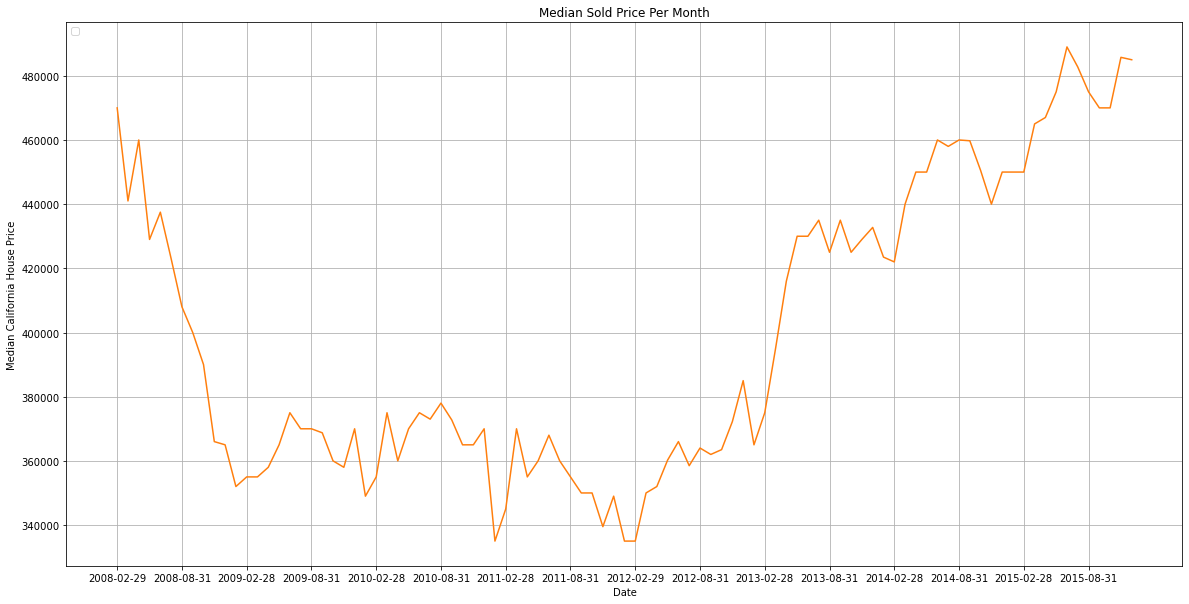

In [51]:
# Doing some EDA with the variables

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(zillow['Date'], zillow['MedianSoldPrice_AllHomes.California'], color='tab:orange')

# Same as above

ax.set_xlabel('Date')
ax.set_ylabel('Median California House Price')
ax.set_title('Median Sold Price Per Month')
ax.set_xticks(dates)
ax.grid(True)
ax.legend(loc='upper left');

No handles with labels found to put in legend.


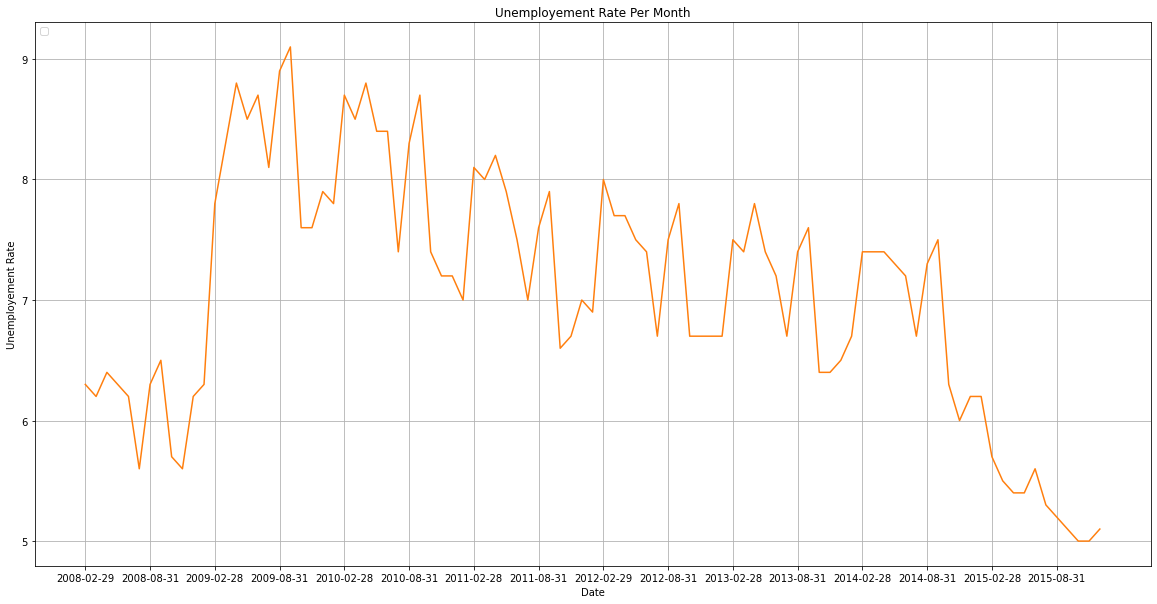

In [52]:
fig_2, ax_2 = plt.subplots(figsize=(20,10))
ax_2.plot(zillow['Date'], zillow['UnemploymentRate'], color='tab:orange')

# Same as above

ax_2.set_xlabel('Date')
ax_2.set_ylabel('Unemployement Rate')
ax_2.set_title('Unemployement Rate Per Month')
ax_2.set_xticks(dates)
ax_2.grid(True)
ax_2.legend(loc='upper left');

No handles with labels found to put in legend.


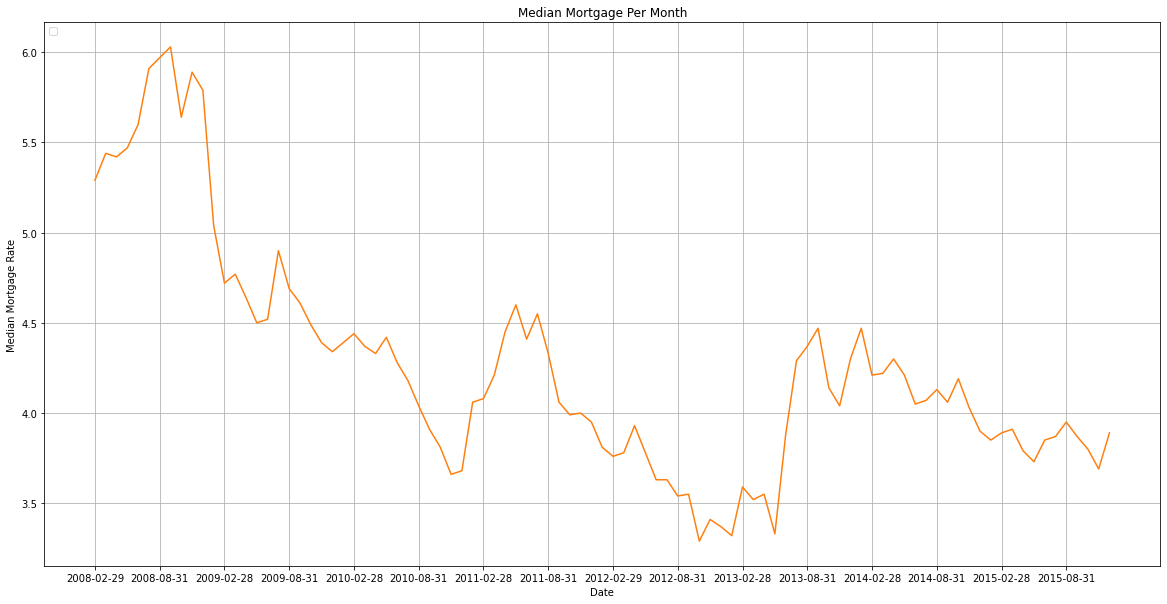

In [53]:
# Doing some EDA with the variables

fig_3, ax_3 = plt.subplots(figsize=(20,10))
ax_3.plot(zillow['Date'], zillow['MedianMortageRate'], color='tab:orange')

# Same as above

ax_3.set_xlabel('Date')
ax_3.set_ylabel('Median Mortgage Rate')
ax_3.set_title('Median Mortgage Per Month')
ax_3.set_xticks(dates)
ax_3.grid(True)
ax_3.legend(loc='upper left');

In [55]:
dftest = adfuller(zillow['MedianSoldPrice_AllHomes.California'], autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


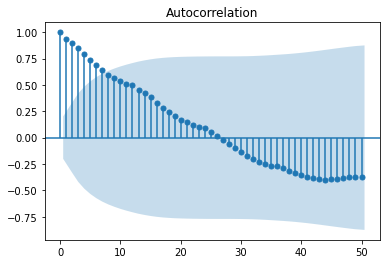

In [58]:
# Check for seasonality

# ACF and PACF plot

plot_acf(zillow['MedianSoldPrice_AllHomes.California'], lags=50)
plt.show()

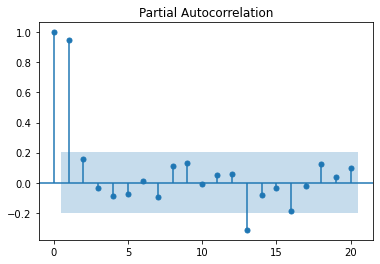

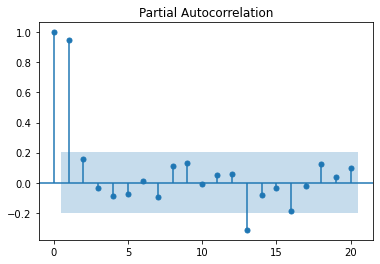

In [59]:
plot_pacf(zillow['MedianSoldPrice_AllHomes.California'], lags=20)

In [62]:
# Fitting a Prophet Model.
df = pd.DataFrame()
df['ds'] = zillow['Date']
df['y'] = zillow['MedianSoldPrice_AllHomes.California']
mean_absolute_percentage_error_prophet(df)

100%|██████████| 19/19 [00:32<00:00,  1.72s/it]


(0.018161709143221193, 10341.844475607553)

In [63]:
# Fitting a Prophet Model with regressor - Umemployement Rate.
df = pd.DataFrame()
df['ds'] = zillow['Date']
df['y'] = zillow['MedianSoldPrice_AllHomes.California']
df['UnemploymentRate'] = zillow['UnemploymentRate']
mean_absolute_percentage_error_prophet_2(df)

100%|██████████| 19/19 [00:31<00:00,  1.67s/it]


(0.01825662191182434, 11079.598481123196)

In [64]:
# Fitting a Prophet Model with regressor - Umemployement Rate.
df = pd.DataFrame()
df['ds'] = zillow['Date']
df['y'] = zillow['MedianSoldPrice_AllHomes.California']
df['MedianMortageRate'] = zillow['MedianMortageRate']
mean_absolute_percentage_error_prophet_3(df)

100%|██████████| 19/19 [00:33<00:00,  1.74s/it]


(0.02066826796924511, 11901.262945120485)